In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch as t
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import einops

from activation_utils import load_model, get_activation_cache, get_embedding_cache
from whitening import compute_whitening_transform, embedding_whitening_transform

/share/u/can/miniconda3/envs/reference_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_id = "google/gemma-2-2b"
model = load_model(model_id)
model.tokenizer.pad_token = model.tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


### Inspect distribution of random webtext activations

In [4]:
# Cache diverse webtext activations
hf_dataset_name = 'skylion007/openwebtext'
num_docs = 2000
ctx_len = 64
batch_size = 64
layers = t.tensor([0, 12, 25])

webtext_cache_LBCD = get_activation_cache(
    model=model,
    hf_dataset_path=hf_dataset_name,
    layers=layers,
    save_activations_path=None,
    num_samples=num_docs,
    max_seq_len=ctx_len,
    llm_batch_size=batch_size,
)

webtext_cache_LTD = einops.rearrange(webtext_cache_LBCD, 'l b c d -> l (b c) d')
webtext_layer0_TD = webtext_cache_LTD[layers == 0].squeeze(0)
webtext_layer12_TD = webtext_cache_LTD[layers == 12].squeeze(0)
webtext_layer25_TD = webtext_cache_LTD[layers == 25].squeeze(0)

Caching activations:   0%|          | 0/31 [00:00<?, ?it/s]

Caching activations: 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]


### Embedding vectors

In [5]:
# Embedding vectors
embed_TD = model.model.embed_tokens.weight.data.to(t.float32)

In [6]:
# Embedding vectors on random webtext
emb_cache_TD = get_embedding_cache(
    model, 
    hf_dataset_name,
    save_activations_path=None,
    num_samples=num_docs, 
    max_seq_len=ctx_len, 
    hf_batch_size=batch_size
)
emb_cache_TD.shape

torch.Size([126976, 2304])

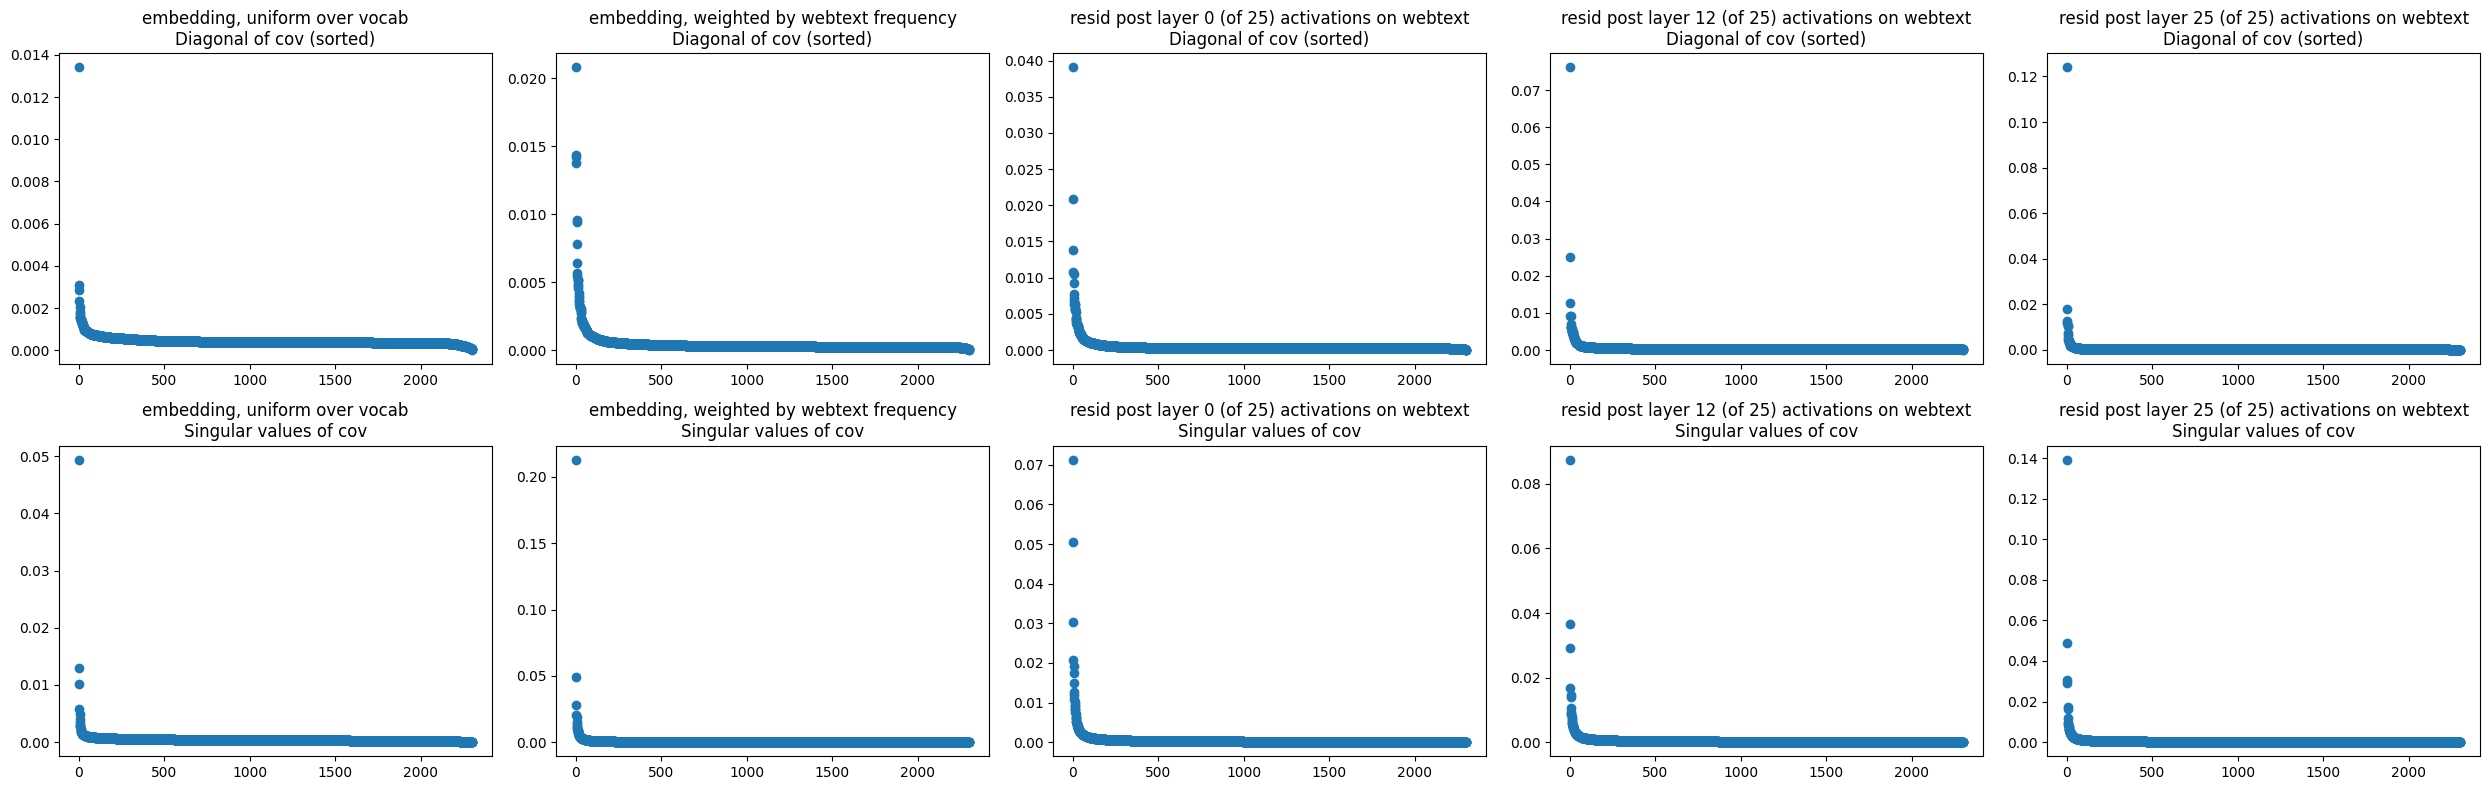

In [17]:
inp_titles = {
    embed_TD: 'embedding, uniform over vocab',
    emb_cache_TD: 'embedding, weighted by webtext frequency',
    webtext_layer0_TD: 'resid post layer 0 (of 25) activations on webtext',
    webtext_layer12_TD: 'resid post layer 12 (of 25) activations on webtext',
    webtext_layer25_TD: 'resid post layer 25 (of 25) activations on webtext',
}
import torch as t
import matplotlib.pyplot as plt

def plot_covariance_analysis(inp_data_dict, plot_flags=None):
    """
    Plot covariance analysis with toggleable subplots.
    
    Args:
        inp_data_dict: Dictionary mapping input tensors to their titles
        plot_flags: Dictionary with keys:
            'show_cov_diag_scatter': bool
            'show_svd': bool
            'show_cov_diag_log': bool
            'show_cov_inv': bool
    """
    if plot_flags is None:
        plot_flags = {
            'show_cov_diag_scatter': True,
            'show_svd': True,
            'show_cov_diag_log': False,
            'show_cov_inv': False
        }
    
    num_plots = sum(plot_flags.values())
    if num_plots == 0:
        raise ValueError("At least one plot type must be enabled")
    
    # Switched dimensions for subplots
    fig, axes = plt.subplots(num_plots, len(inp_data_dict), 
                            figsize=(5*len(inp_data_dict), 4*num_plots),
                            squeeze=False)
    
    for col, (inp, title) in enumerate(inp_data_dict.items()):
        # Normalize data
        diverse_acts = (inp - inp.mean(dim=0, keepdim=True))
        diverse_acts = diverse_acts / diverse_acts.norm(dim=1, keepdim=True)
        
        # Compute covariance matrix
        cov = t.cov(diverse_acts.T)
        
        row = 0
        
        # Plot 1: Covariance diagonal scatter
        if plot_flags['show_cov_diag_scatter']:
            cov_diagonal = t.sort(cov.diag(), descending=True).values
            axes[row, col].scatter(range(cov_diagonal.shape[0]), cov_diagonal.cpu())
            axes[row, col].set_title(f'{title}\nDiagonal of cov (sorted)')
            row += 1
        
        # Plot 2: SVD values
        if plot_flags['show_svd']:
            U, S, V = t.svd(cov)
            axes[row, col].scatter(range(S.shape[0]), S.cpu())
            axes[row, col].set_title(f'{title}\nSingular values of cov')
            row += 1
        
        # Plot 4: Inverse covariance diagonal
        if plot_flags['show_cov_inv']:
            cov_inv = t.linalg.inv(cov)
            axes[row, col].plot(cov_inv.diag().cpu())
            axes[row, col].set_yscale('log')
            axes[row, col].set_title(f'{title}\nDiagonal of cov^-1')
            print(f'max diagonal value of cov^-1: {cov_inv.max()}')
            print(f'max off-diagonal value of cov^-1: {cov_inv.flatten()[t.eye(cov_inv.shape[0]).flatten() == 0].max()}')
            row += 1
    
    plt.tight_layout()
    return fig, axes

# Example usage:
plot_flags = {
    'show_cov_diag_scatter': True,
    'show_svd': True,
    'show_cov_inv': False
}
fig, axes = plot_covariance_analysis(inp_titles, plot_flags)
plt.show()

# Optionally shrink outlier dimensions

In [8]:
whitening_transform_save_path = '/share/u/can/by_reference/data/gemma2-2b_whitening_transform.pt'
cov_inv = compute_whitening_transform(emb_cache_TD, save_path=whitening_transform_save_path)

In [ ]:
cov_inv = embedding_whitening_transform(model)

def dist(x, y):
    return x @ cov_inv @ y

: 

### Load and whiten activations

In [4]:
fname = '/share/u/can/by_reference/data/box_source_activations.pt'
with open(fname, 'rb') as f:
    act_LBED = t.load(f)

/tmp/ipykernel_927399/873835121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  act_LBED = t.load(f)
